In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error,r2_score
import gradio as gr
import warnings
warnings.filterwarnings('ignore')

In [2]:
food = pd.read_csv('/content/Food_Delivery_Route_Efficiency_Dataset.csv')
food.head()

,order_id,distance_km,delivery_time_min,traffic_level,route_length_km,delivery_mode,weather,order_time,restaurant_zone,customer_zone
0,1,7.97,63.8,High,9.75,Bicycle,Clear,2025-01-01 15:29,South,North
1,2,0.90,7.6,High,1.28,Car,Cloudy,2025-01-03 00:47,West,North
2,3,11.12,78.0,Medium,16.65,Bike,Rainy,2025-01-04 17:32,South,Central
3,4,4.90,24.8,Low,5.25,Scooter,Rainy,2025-01-01 14:12,Central,Central
4,5,10.04,56.0,High,11.34,Car,Rainy,2025-01-02 16:50,West,North


In [3]:
food = food.drop(['order_id','order_time'], axis=1)
food.head()

,distance_km,delivery_time_min,traffic_level,route_length_km,delivery_mode,weather,restaurant_zone,customer_zone
0,7.97,63.8,High,9.75,Bicycle,Clear,South,North
1,0.90,7.6,High,1.28,Car,Cloudy,West,North
2,11.12,78.0,Medium,16.65,Bike,Rainy,South,Central
3,4.90,24.8,Low,5.25,Scooter,Rainy,Central,Central
4,10.04,56.0,High,11.34,Car,Rainy,West,North


In [4]:
food.isnull().sum()

,0
distance_km,0
delivery_time_min,0
traffic_level,0
route_length_km,0
delivery_mode,0
weather,0
restaurant_zone,0
customer_zone,0


In [5]:
food.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   distance_km        200 non-null    float64
 1   delivery_time_min  200 non-null    float64
 2   traffic_level      200 non-null    object 
 3   route_length_km    200 non-null    float64
 4   delivery_mode      200 non-null    object 
 5   weather            200 non-null    object 
 6   restaurant_zone    200 non-null    object 
 7   customer_zone      200 non-null    object 
dtypes: float64(3), object(5)
memory usage: 12.6+ KB


## Route Optimization & Path Efficiency

In [6]:
food['inefficiency'] = food['route_length_km'] / food['distance_km']
food.head()

,distance_km,delivery_time_min,traffic_level,route_length_km,delivery_mode,weather,restaurant_zone,customer_zone,inefficiency
0,7.97,63.8,High,9.75,Bicycle,Clear,South,North,1.223338
1,0.90,7.6,High,1.28,Car,Cloudy,West,North,1.422222
2,11.12,78.0,Medium,16.65,Bike,Rainy,South,Central,1.497302
3,4.90,24.8,Low,5.25,Scooter,Rainy,Central,Central,1.071429
4,10.04,56.0,High,11.34,Car,Rainy,West,North,1.129482


In [7]:
food.groupby('delivery_mode')['inefficiency'].mean().rank(ascending=False)

,inefficiency
delivery_mode,
Bicycle,1.0
Bike,2.0
Car,3.0
Scooter,4.0


In [8]:
food.groupby('restaurant_zone')['inefficiency'].mean().rank(ascending=False)

,inefficiency
restaurant_zone,
Central,4.0
East,1.0
North,5.0
South,3.0
West,2.0


In [9]:
food.groupby('customer_zone')['inefficiency'].mean().rank(ascending=False)

,inefficiency
customer_zone,
Central,4.0
East,5.0
North,2.0
South,1.0
West,3.0


## Traffic Impact Analysis

In [10]:
food['speed_km_per_min'] = food['distance_km'] / food['delivery_time_min']

traffic_summary = food.groupby('traffic_level').agg(
    avg_delivery_time_min=('delivery_time_min', 'mean'),
    avg_speed_km_per_min=('speed_km_per_min', 'mean')
).reset_index()

traffic_summary

,traffic_level,avg_delivery_time_min,avg_speed_km_per_min
0,High,45.619118,0.160453
1,Low,47.047692,0.149279
2,Medium,41.622388,0.156431


## Zone-Based Operational Insights

In [11]:
zone_summary = food.groupby(['restaurant_zone', 'customer_zone']).agg(
    avg_distance_km=('distance_km', 'mean'),
    avg_delivery_time_min=('delivery_time_min', 'mean'),
    avg_route_length_km=('route_length_km', 'mean'),
    delivery_count=('delivery_time_min', 'count')
).reset_index()

zone_summary

,restaurant_zone,customer_zone,avg_distance_km,avg_delivery_time_min,avg_route_length_km,delivery_count
0,Central,Central,6.838571,43.185714,8.350000,7
1,Central,East,7.342000,49.950000,8.622000,10
2,Central,North,5.246667,32.022222,6.900000,9
3,Central,South,7.212727,46.927273,8.710909,11
4,Central,West,6.691000,45.490000,8.492000,10
5,East,Central,6.466000,44.800000,8.162000,5
6,East,East,6.856250,52.400000,8.961250,8
7,East,North,7.048571,50.142857,8.484286,7
8,East,South,8.850000,60.625000,11.285000,4
9,East,West,7.630000,46.525000,9.417500,4


## Weather Impact Analysis

In [12]:
food['speed_km_per_min'] = food['distance_km'] / food['delivery_time_min']

weather_summary = food.groupby('weather').agg(
    avg_delivery_time_min=('delivery_time_min', 'mean'),
    avg_speed_km_per_min=('speed_km_per_min', 'mean'),
    avg_distance_km=('distance_km', 'mean'),
    delivery_count=('delivery_time_min', 'count')
).reset_index()

weather_summary

,weather,avg_delivery_time_min,avg_speed_km_per_min,avg_distance_km,delivery_count
0,Clear,42.267500,0.159223,6.343750,40
1,Cloudy,49.943636,0.151321,7.292909,55
2,Rainy,42.776364,0.157290,6.348545,55
3,Windy,43.172000,0.155047,6.418400,50


## Exploratory Data Analysis

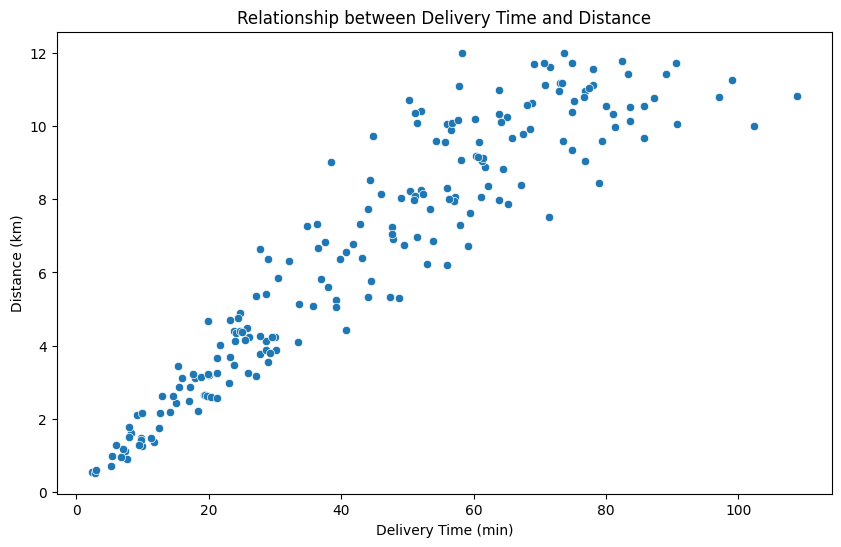

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=food, x='delivery_time_min', y='distance_km')
plt.title('Relationship between Delivery Time and Distance')
plt.xlabel('Delivery Time (min)')
plt.ylabel('Distance (km)')
plt.show()

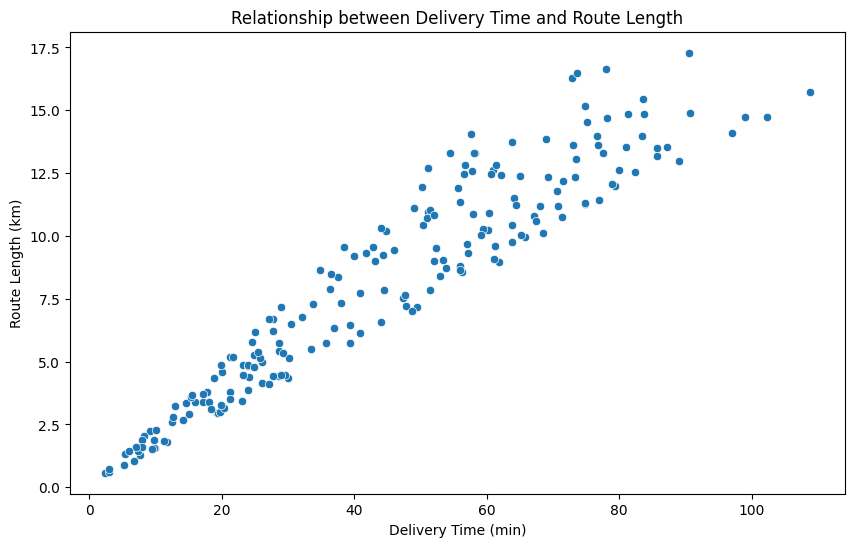

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=food, x='delivery_time_min', y='route_length_km')
plt.title('Relationship between Delivery Time and Route Length')
plt.xlabel('Delivery Time (min)')
plt.ylabel('Route Length (km)')
plt.show()

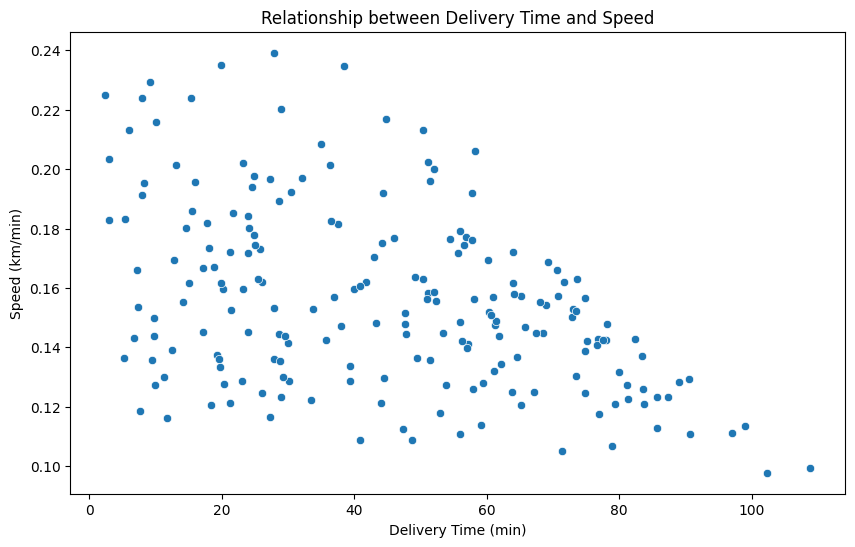

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=food, x='delivery_time_min', y='speed_km_per_min')
plt.title('Relationship between Delivery Time and Speed')
plt.xlabel('Delivery Time (min)')
plt.ylabel('Speed (km/min)')
plt.show()

In [16]:
for col in food:
    if food[col].dtype == 'O':
        codes, _ = pd.factorize(food[col])
        food[col] = codes + 1

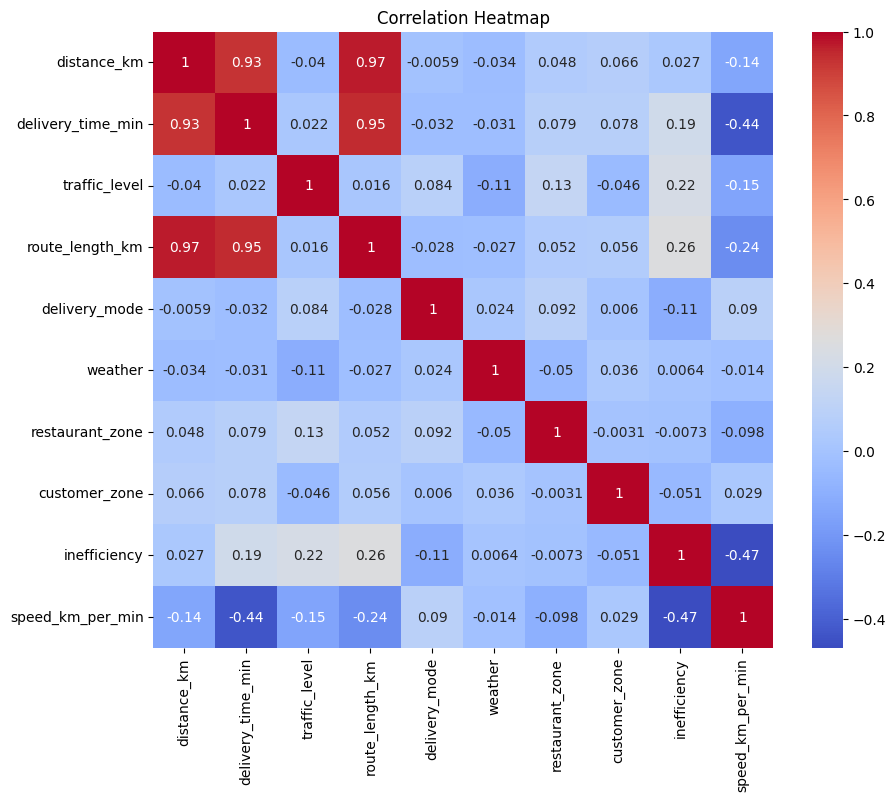

In [17]:
food_corr = food.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(food_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## AdaBoost Regressor

In [18]:
X = food.drop('delivery_time_min', axis=1)
y = food['delivery_time_min']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
food_clf = AdaBoostRegressor(n_estimators=100, random_state=0)
food_clf.fit(X, y)

AdaBoostRegressor(n_estimators=100, random_state=0)

In [21]:
y_pred = food_clf.predict(X)

In [22]:
print('Mean Absolute Error:', mean_absolute_error(y, y_pred))
print('R-squared:', r2_score(y, y_pred))

Mean Absolute Error: 3.059618537937663
R-squared: 0.9795657939392457


## Gradient Boosting Regressor

In [23]:
food_gradient = GradientBoostingRegressor(n_estimators=50, random_state=0)
food_gradient.fit(X, y)

GradientBoostingRegressor(n_estimators=50, random_state=0)

In [24]:
y_pred = food_gradient.predict(X)

In [25]:
print('Mean Absolute Error:', mean_absolute_error(y, y_pred))
print('R-squared:', r2_score(y, y_pred))

Mean Absolute Error: 0.7880349262506394
R-squared: 0.9983677136517739


## Random Forest Regressor

In [26]:
food_random = RandomForestRegressor(n_estimators=100, random_state=0)
food_random.fit(X, y)

RandomForestRegressor(random_state=0)

In [27]:
y_pred = food_random.predict(X)

In [28]:
print('Mean Absolute Error:', mean_absolute_error(y, y_pred))
print('R-squared:', r2_score(y, y_pred))

Mean Absolute Error: 0.9852850000000002
R-squared: 0.9970245891150759


## Decision Tree Regressor

In [29]:
food_decision = DecisionTreeRegressor(max_depth= 4, min_weight_fraction_leaf=0.1)
food_decision.fit(X, y)

DecisionTreeRegressor(max_depth=4, min_weight_fraction_leaf=0.1)

In [30]:
y_pred = food_decision.predict(X)

In [31]:
print('Mean Absolute Error:', mean_absolute_error(y, y_pred))
print('R-squared:', r2_score(y, y_pred))

Mean Absolute Error: 5.185617127496161
R-squared: 0.9264339776986411


## XGBoost Regressor

In [32]:
food_xgb = xgb.XGBRegressor(n_estimators=150, max_depth = 3, learning_rate = 0.01, random_state=0)
food_xgb.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=150,
             n_jobs=None, num_parallel_tree=None, ...)

In [33]:
y_pred = food_xgb.predict(X)

In [34]:
print('Mean Absolute Error:', mean_absolute_error(y, y_pred))
print('R-squared:', r2_score(y, y_pred))

Mean Absolute Error: 5.755091876983642
R-squared: 0.9189679723655044


In [35]:
def predict_delivery_time(
    distance_km: float,
    traffic_level: int,
    route_length_km: float,
    delivery_mode: int,
    weather: int,
    restaurant_zone: int,
    customer_zone: int,
    inefficiency: float,
    speed_km_per_min: float
) -> float:
    input_data = pd.DataFrame([[distance_km, traffic_level, route_length_km, delivery_mode, weather, restaurant_zone, customer_zone, inefficiency, speed_km_per_min]],
                                columns=X.columns)

    prediction = food_xgb.predict(input_data)[0]
    return prediction

inputs = [
    gr.Number(label="Distance (km)", info="e.g., 7.97"),
    gr.Dropdown(label="Traffic Level", choices={1: 'High', 2: 'Medium', 3: 'Low'}, value=1, info="1: High, 2: Medium, 3: Low"),
    gr.Number(label="Route Length (km)", info="e.g., 9.75"),
    gr.Dropdown(label="Delivery Mode", choices={1: 'Bicycle', 2: 'Car', 3: 'Bike', 4: 'Scooter'}, value=1, info="1: Bicycle, 2: Car, 3: Bike, 4: Scooter"),
    gr.Dropdown(label="Weather", choices={1: 'Clear', 2: 'Cloudy', 3: 'Rainy', 4: 'Windy'}, value=1, info="1: Clear, 2: Cloudy, 3: Rainy, 4: Windy"),
    gr.Dropdown(label="Restaurant Zone", choices={1: 'South', 2: 'West', 3: 'Central', 4: 'East', 5: 'North'}, value=1, info="1: South, 2: West, 3: Central, 4: East, 5: North"),
    gr.Dropdown(label="Customer Zone", choices={1: 'North', 2: 'Central', 3: 'West', 4: 'South', 5: 'East'}, value=1, info="1: North, 2: Central, 3: West, 4: South, 5: East"),
    gr.Number(label="Inefficiency (route_length_km / distance_km)", info="e.g., 1.22"),
    gr.Number(label="Speed (km/min)", info="e.g., 0.16")
]

outputs = gr.Number(label="Predicted Delivery Time (min)")

interface = gr.Interface(
    fn=predict_delivery_time,
    inputs=inputs,
    outputs=outputs,
    title="Food Delivery Time Prediction",
    description="Enter the delivery parameters to predict the delivery time in minutes."
)

interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f2baa1562f7257b030.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
